In [358]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [359]:
class TraderAgent(mesa.Agent):
    """Base class for all trader agents."""
    def __init__(self, model: mesa.Model):
        super().__init__(model)
        self.cash = 10_000  # Starting cash
        self.shares = 10    # Starting shares
        self.agent_type = "Trader"
        
    def step(self):
        # This method will be called at each step of the simulation.
        # Meant to be overridden by subclasses.
        pass
    
    def update_psychological_state(self):
        # Logic for calculating new (x, y) based on price change and
        # neighbors, then moving the agent on the grid appropriately.
        pass
    
class FundamentalistAgent(TraderAgent):
    """A trader who bases decisions on a calculated intrinsic value."""
    def __init__(self, model: mesa.Model, intrinsic_value):
        super().__init__(model)
        self.intrinsic_value = intrinsic_value
        self.agent_type = "Fundamentalist"
        
    def step(self):
        valuation = self.pos[1]
        trade_threshold = 0.1
        
        if valuation > trade_threshold:
            # Perceived as overvalued, so sell.
            # The more overvalued, the stronger the urge to sell.
            volume = int(abs(valuation) * 10)
            self.model.submit_sell_order(self, volume)
            
        elif valuation < -trade_threshold:
            # Perceived as undervalued, so buy.
            volume = int(abs(valuation) * 10)
            self.model.submit_buy_order(self, volume)
            
    def update_psychological_state(self):
        """
        Updates state based on the new price.
        Sentiment (x-axis) decays, while valuation (y-axis) is recalculated.
        """
        # Recalculate valuation based on the new price
        price_deviation = (self.model.price - self.intrinsic_value) / self.intrinsic_value
        new_y = price_deviation
        
        # Sentiment is unemotional and always decays back to neutral (0)
        new_x = self.pos[0] * 0.5
        
        # Move agent to new psychological state
        new_pos = np.clip([new_x, new_y], -1, 1)
        self.model.grid.move_agent(self, tuple(new_pos))

In [360]:
class ChartistAgent(TraderAgent):
    """A trader who uses technical analysis, specifically Bollinger Bands and short-term price momentum to make decisions."""
    def __init__(self, model: mesa.Model, lookback_period=20, std_devs=2):
        super().__init__(model)
        self.agent_type = "Chartist"
        self.lookback_period = lookback_period
        self.std_devs = std_devs
        
    def step(self):
        """
        Acts based on technical valuation (y-axis). This represents a mean-reversion strategy using Bollinger Bands.
        If the price is perceived as "overbought" (near upper band), sell.
        If the price is perceived as "oversold" (near lower band), buy.
        """
        technical_valuation = self.pos[1]
        trade_threshold = 0.8  # Trade only at the extremes of the bands
        
        if technical_valuation > trade_threshold:
            # Stock is overbought, expect a reversion, so SELL.
            self.model.submit_sell_order(self, 15)
        elif technical_valuation < -trade_threshold:
            # Stock is oversold, expect a reversion, so BUY.
            self.model.submit_buy_order(self, 15)
            
    def update_psychological_state(self):
        """
        Updates state based on Bollinger Bands and price momentum.
        Y-axis: Where the price is relative to its band.
        X-axis: The market's short-term price action/momentum.  
        """
        history = self.model.price_history
        if len(history) < self.lookback_period:
            return  # Not enough data
        
        # --- Y-Axis (Valuation) Calculation using Bollinger Bands ---
        relevant_history = history[-self.lookback_period:]
        sma = np.mean(relevant_history)
        std_dev = np.std(relevant_history)
        std_dev = max(std_dev, 1e-6)  # Prevent division by zero is price has been flat
        
        upper_band = sma + self.std_devs * std_dev
        lower_band = sma - self.std_devs * std_dev
        
        # Avoid division by zero if bands are flat
        if upper_band == lower_band:
            new_y = 0
        else:
            # Normalize price position within the bands to a -1 to 1 scale
            # y=0 is the SMA, y=1 is the upper band, y=-1 is the lower band
            if self.model.price > sma:
                new_y = (self.model.price - sma) / (upper_band - sma)
            else:
                new_y = (self.model.price - sma) / (sma - lower_band)
        
        # --- X-Axis (Sentiment) Calculation using Price Action ---
        # The model calculates short_term_momentum for us.
        # We use tanh to squash the momentum into the -1 to 1 range.
        # The sensitivity factor determines how quickly sentiment shifts.
        momentum_sensitivity = 4.0
        new_x = np.tanh(self.model.short_term_momentum * momentum_sensitivity)
        
        # --- Move agent to its new psychological state ---
        new_pos = np.clip([new_x, new_y], -1.0, 1.0)
        self.model.grid.move_agent(self, tuple(new_pos))

In [361]:
from random import choice
class NoiseTraderAgent(TraderAgent):
    """A wildcard agent driven by herding, momentum, and impulse."""
    def __init__(self, model):
        super().__init__(model)
        self.agent_type = "NoiseTrader"
        self.herd_influence_factor = 0.3  # how much impact neighbors have
        self.momentum_sensitivity = choice([5.0, 8.0, 10.0, 12.0]) # how strongly they react to price changes
        self.random_shock_strength = 0.1  # gut feelings I guess
        
    def step(self):
        """Trades impulsively based on sentiment."""
        sentiment = self.pos[0]
        fomo_threshold = 0.8
        panic_threshold = -0.8
        
        if sentiment > fomo_threshold:
            # High emotion -> BUY
            self.model.submit_buy_order(self, 20)
        elif sentiment < panic_threshold:
            # High panic -> SELL
            self.model.submit_sell_order(self, 20)
            
    def update_psychological_state(self):
        """State is a chaotic mix of their old state, the herd's state, market momentum, and impulse."""
        # Get herd influence
        all_positions = np.array([
            n.pos for n in self.model.agents
            if n.unique_id != self.unique_id
        ])
        avg_herd_pos = np.mean(all_positions, axis=0)
        
        # New valuation is based on combination of previous state and herd state
        new_x = (1 - self.herd_influence_factor) * self.pos[0] + self.herd_influence_factor * avg_herd_pos[0]
        new_y = (1 - self.herd_influence_factor) * self.pos[1] + self.herd_influence_factor * avg_herd_pos[1]
        new_pos = [new_x, new_y]
        
        # Add influence from market momentum (affects sentiment only)
        momentum_effect = np.tanh(self.model.short_term_momentum * self.momentum_sensitivity)
        new_pos[0] += momentum_effect
        
        # Simulate "gut feelings" with randomness
        randomness = self.model.np_random.uniform(-1, 1, 2) * self.random_shock_strength
        new_pos += randomness
        
        new_pos = np.clip(new_pos, -1, 1)
        
        self.model.grid.move_agent(self, tuple(new_pos))

In [362]:
class MarketModel(mesa.Model):
    """Model with util methods for market simulation."""
    def __init__(self, n_fundamentalists: int, n_chartists: int, n_noise_traders: int, volatility=0.005, seed=None):
        super().__init__()
        self.np_random = np.random.default_rng(seed)
        self.num_agents = n_fundamentalists + n_chartists + n_noise_traders
        
        self.volatility = volatility 
        self.initial_price = 100.0
        self.true_intrinsic_value = 100.0
        self.price_impact_factor = 0.01  # How much net demand affects the price
        self.momentum_window = 5  # For the price action indicator
        
        self.grid = mesa.space.ContinuousSpace(
            x_max=np.nextafter(1, 2),
            y_max=np.nextafter(1, 2),
            torus=False,
            x_min=-1,
            y_min=-1,
        )
        
        self.price = self.initial_price
        self.price_history = np.linspace(
            self.price - 6,
            self.price,
            30,
        ).tolist()
        self.short_term_momentum = 0.0
        self.total_buy_volume = 0
        self.total_sell_volume = 0
        self.update_indicators()
        
        for a in range(n_fundamentalists):
            f_val = self.random.gauss(self.true_intrinsic_value, 2)
            agent = FundamentalistAgent(self, f_val)
            self.grid.place_agent(agent, (0.0,0.0))
            
        for a in range(n_chartists):
            agent = ChartistAgent(self)
            self.grid.place_agent(agent, tuple(self.np_random.uniform(-0.3, 0.3, 2)))
            
        for a in range(n_noise_traders):
            agent = NoiseTraderAgent(self)
            self.grid.place_agent(agent, tuple(self.np_random.uniform(-0.8, 0.8, 2)))
            
        for agent in self.agents:
            agent.update_psychological_state()
            
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price"},
            agent_reporters={
                "Position": "pos",
                "AgentType": "agent_type",
            },
        )
        
    def submit_buy_order(self, agent, volume):
        self.total_buy_volume += volume
        
    def submit_sell_order(self, agent, volume):
        self.total_sell_volume += volume
        
    def update_indicators(self):
        """Calculate stock indicators."""
        if len(self.price_history) > self.momentum_window:
            price_then = self.price_history[-self.momentum_window]
            if price_then > 0:
                self.short_term_momentum = (self.price - price_then) / price_then
        
    def step(self):
        # Reset book for this step
        self.total_buy_volume = 0
        self.total_sell_volume = 0
        
        # Agents decide to act based on their current state
        self.agents.shuffle_do("step")
        
        # Calculate price change from agent actions
        net_demand = self.total_buy_volume - self.total_sell_volume
        price_change_factor = np.tanh(net_demand / self.num_agents)
        demand_driven_change = price_change_factor * self.price_impact_factor
        
        # Add some market noise (random news, shareholder meetings, etc)
        stochastic_shock = self.np_random.normal(0, self.volatility)
        
        # Calculate new price
        self.price *= (1 + demand_driven_change + stochastic_shock)
        self.price = max(0.01, self.price)
        self.price_history.append(self.price)
        self.update_indicators()
        
        # update agents' psychological state from new price
        for agent in self.agents:
            agent.update_psychological_state()
            
        self.datacollector.collect(self)

In [363]:
SIMULATION_STEPS = 1000
NUM_FUNDAMENTALISTS = 10
NUM_CHARTISTS = 20
NUM_NOISE_TRADERS = 40


model = MarketModel(
    NUM_FUNDAMENTALISTS, 
    NUM_CHARTISTS,
    NUM_NOISE_TRADERS,
)
for i in range(SIMULATION_STEPS):
    model.step()
print("Simulation complete.")

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

Simulation complete.


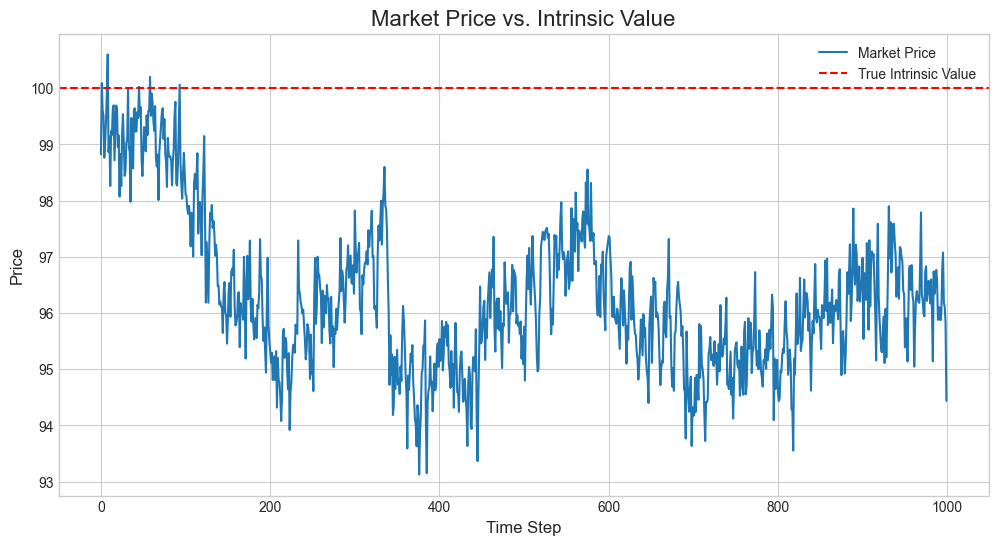

In [364]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
model_data['Price'].plot(ax=ax, label='Market Price')
ax.axhline(model.true_intrinsic_value, color='red', linestyle='--', label='True Intrinsic Value')
ax.set_title('Market Price vs. Intrinsic Value', fontsize=16)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()
plt.show()

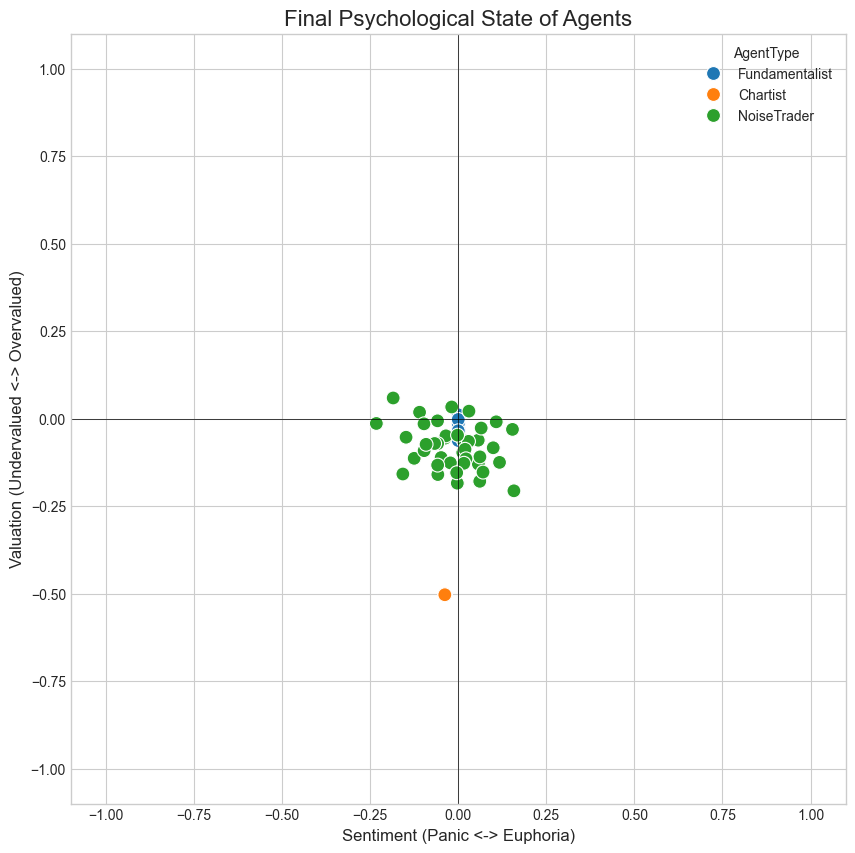

In [365]:
final_step_data = agent_data.loc[SIMULATION_STEPS - 1]
final_step_data['x'] = final_step_data['Position'].apply(lambda pos: pos[0])
final_step_data['y'] = final_step_data['Position'].apply(lambda pos: pos[1])

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=final_step_data, x='x', y='y', hue='AgentType', ax=ax, s=100)

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Final Psychological State of Agents', fontsize=16)
ax.set_xlabel('Sentiment (Panic <-> Euphoria)', fontsize=12)
ax.set_ylabel('Valuation (Undervalued <-> Overvalued)', fontsize=12)
ax.grid(True)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(0, color='k', linestyle='-', linewidth=0.5)
plt.show()